In [767]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [768]:
# read in all the words
words = [x.lower() for x in list(open('male_names_rus.txt', 'r').read().splitlines())]
words[:8]

['аарон',
 'аба',
 'аббас',
 'абд аль-узза',
 'абдуллах',
 'абид',
 'аботур',
 'аввакум']

In [769]:
len(words)

736

In [770]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: '-', 3: 'а', 4: 'б', 5: 'в', 6: 'г', 7: 'д', 8: 'е', 9: 'ж', 10: 'з', 11: 'и', 12: 'й', 13: 'к', 14: 'л', 15: 'м', 16: 'н', 17: 'о', 18: 'п', 19: 'р', 20: 'с', 21: 'т', 22: 'у', 23: 'ф', 24: 'х', 25: 'ц', 26: 'ч', 27: 'ш', 28: 'ы', 29: 'ь', 30: 'э', 31: 'ю', 32: 'я', 33: 'ё', 0: '.'}


In [771]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [772]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([5285, 3]), torch.int64, torch.Size([5285]), torch.int64)

In [773]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([4206, 3]) torch.Size([4206])
torch.Size([550, 3]) torch.Size([550])
torch.Size([529, 3]) torch.Size([529])


In [774]:
g = torch.Generator().manual_seed(52) # for reproducibility
class Linear():
  def __init__(self, input_n, output_n, bias=True):
    self.W = torch.randn((input_n, output_n), generator=g)
    if bias:
      self.b = torch.randn(output_n, generator=g)
    else:
      self.b = torch.zeros(output_n)
    self.W.requires_grad = True
    self.b.requires_grad = True
  def __call__(self, x):
    return x @ self.W + self.b

In [775]:
class Net():
  def __init__(self, input_n, output_n):
    self.l1 = Linear(input_n, 256)
    self.f1 = torch.tanh
    self.l2 = Linear(256, 256)
    self.f2 = torch.tanh
    self.l3 = Linear(256, 128)
    self.f3 = torch.tanh
    self.l4 = Linear(128, 128)
    self.f4 = torch.tanh
    self.l5 = Linear(128, 64)
    self.f5 = torch.tanh
    self.l6 = Linear(64, 34)
    self.funcs = [self.l1, self.f1, self.l2, self.f2, self.l3, self.f3, self.l4, self.f4, self.l5, self.f5, self.l6]
  def forward(self, x):
    for func in self.funcs:
      x = func(x)
    return x

In [776]:
C = torch.randn((34, 10), generator=g)
net = Net(30, 34)

In [777]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [778]:
lri = []
lossi = []
stepi = []
lossi_train = []

In [779]:
for i in range(20000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (16,))

  # forward pass
  emb = C[Xtr[ix]]
  logits = net.forward(emb.view(-1, 30))
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in net.funcs:
    try:
      p.W.grad = None
      p.b.grad = None
    except:
      pass
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in net.funcs:
    try:
      p.W.data += -lr * p.W.grad
      p.b.data += -lr * p.b.grad
    except:
      pass

  # track stats
  #lri.append(lre[i])
  if i % 100 == 0:
    ix = torch.randint(0, Xte.shape[0], (2048,))
    emb = C[Xte[ix]]
    logits = net.forward(emb.view(-1, 30))
    loss_test = F.cross_entropy(logits, Yte[ix])
    stepi.append(i)
    lossi.append(loss_test.log10().item())
    lossi_train.append(loss.log10().item())
    print(f"Epoch: {i}; Loss_train: {loss.item()}; Loss_test: {loss_test.item()}")

#print(loss.item())

Epoch: 0; Loss_train: 16.34247398376465; Loss_test: 15.340606689453125
Epoch: 100; Loss_train: 8.463848114013672; Loss_test: 8.391641616821289
Epoch: 200; Loss_train: 4.487124919891357; Loss_test: 6.414804458618164
Epoch: 300; Loss_train: 5.618846416473389; Loss_test: 5.335936069488525
Epoch: 400; Loss_train: 4.540241241455078; Loss_test: 4.71715784072876
Epoch: 500; Loss_train: 3.7658047676086426; Loss_test: 4.3599534034729
Epoch: 600; Loss_train: 4.598803520202637; Loss_test: 4.047466278076172
Epoch: 700; Loss_train: 3.5033833980560303; Loss_test: 4.1036882400512695
Epoch: 800; Loss_train: 3.9640066623687744; Loss_test: 3.985469341278076
Epoch: 900; Loss_train: 3.1012802124023438; Loss_test: 3.8196237087249756
Epoch: 1000; Loss_train: 3.875452995300293; Loss_test: 3.660849094390869
Epoch: 1100; Loss_train: 2.327709197998047; Loss_test: 3.476576805114746
Epoch: 1200; Loss_train: 3.344850778579712; Loss_test: 3.3574445247650146
Epoch: 1300; Loss_train: 3.4523768424987793; Loss_test: 3.

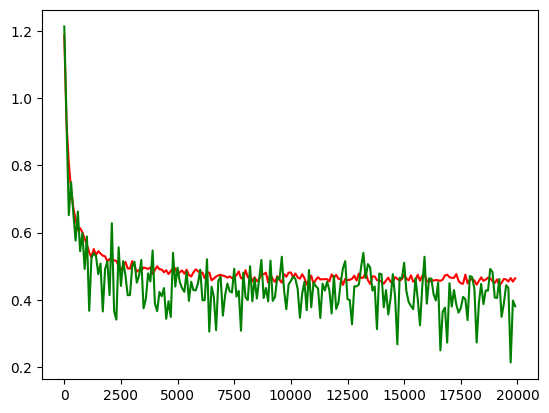

In [787]:
plt.plot(stepi, lossi, color='red')
plt.plot(stepi, lossi_train, color='green')

In [788]:
emb = C[Xtr]
logits = net.forward(emb.view(-1, 30))
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4866, grad_fn=<NllLossBackward0>)

In [790]:
emb = C[Xdev]
logits = net.forward(emb.view(-1, 30))
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.9507, grad_fn=<NllLossBackward0>)

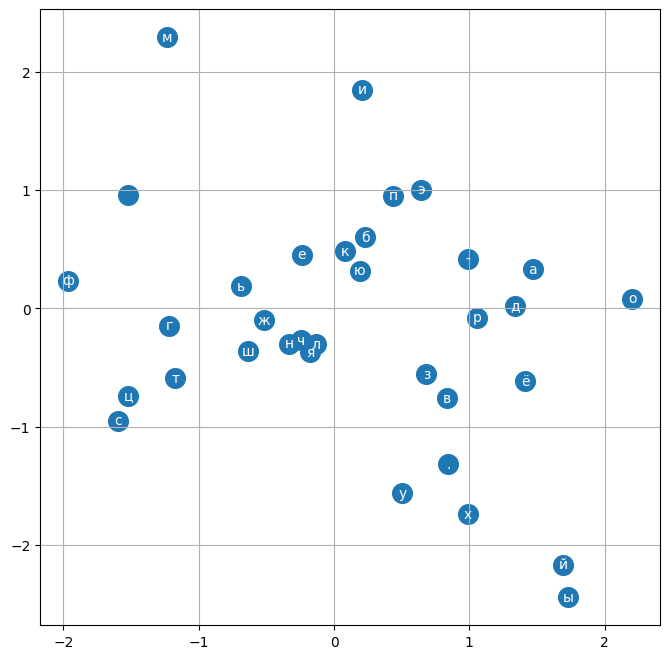

In [791]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [792]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [793]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [794]:


# sample from the model
g = torch.Generator().manual_seed(1)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      logits = net.forward(emb.view(-1, 30))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

стеваер.
ват.
асдхе.
ано.
сед.
станлин.
кжсшьнаа.
тарас.
саварсеисфвчмон.
судаетанаа.
генв.
истанрбари.
элисойватьй.
лол.
колино.
ванримн.
ас.
рдклаттефам.
тукек.
уникерсбвыуний.
